In [1]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
from typing import Optional, Literal, Union

# we use a local copy of the fast_soft_sort manually downloaded from
# https://github.com/google-research/fast-soft-sort/tree/master
from fast_soft_sort.pytorch_ops import soft_rank

## Differentiable proxy to Spearman corr

Based on the ["Fast Differentiable Sorting and Ranking"](https://arxiv.org/abs/2002.08871) article and [their implementation](https://github.com/google-research/fast-soft-sort/). Further inspiration for the implimentation of the Spearman corr taken from [here](https://forum.numer.ai/t/differentiable-spearman-in-pytorch-optimize-for-corr-directly/2287) and for the XGBoost custom objective function from [here](https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960).

One of the limitations of the **fast-soft-sort** implementations is that the soft rank is only once differenciable (seemingly the artifact of the implementation of the core functions in numpy). There is [another implementation](https://github.com/teddykoker/torchsort) of the same functions fully written in Pytorch and cpp. However, it requires installation of a cpp compiler and was not tested here due to the absence of admin rights on Windows.

First test `soft_rank` func:

In [2]:
torch.manual_seed(0)
vals = torch.tensor([[1., 10., -3.5, 0.2]]) # true ranks = [3, 4, 1, 2]
regularization = "kl"
regularization_strength = 1e+1

for rs in [1e-4, 1e-0, 1e+1]:
    sr = soft_rank(vals, regularization=regularization, regularization_strength=rs)
    print(f'regularization = {rs}\tranks = {", ".join([f"{v:.4f}" for v in sr[0].numpy()])}')

regularization = 0.0001	ranks = 3.0001, 3.9861, 1.0000, 1.9999
regularization = 1.0	ranks = 3.0000, 4.0000, 1.0000, 2.0000
regularization = 10.0	ranks = 2.3431, 4.0000, 1.4940, 2.1629


Implement code for the Spearman corr proxy:

In [3]:
def corrcoef(ytrue: torch.tensor, ypred: torch.tensor) -> float:
    """Calculate Pearson correlation coeff."""
    ypred_n = ypred - ypred.mean()
    ytrue_n = ytrue - ytrue.mean()
    ypred_n = ypred_n / ypred_n.norm()
    ytrue_n = ytrue_n / ytrue_n.norm()
    
    return (ypred_n * ytrue_n).sum()

def spearman_proxy(
    ytrue: torch.tensor,
    ypred: torch.tensor,
    regularization: Optional[Literal["l2", "kl"]] = "l2",
    regularization_strength: Optional[float] = 0.0001
    ) -> float:
    """Calculate differantiable proxy to Spearman corr."""
    # calculate soft (differantiable) rank
    ytrue_rank = soft_rank(
        ytrue,
        regularization=regularization,
        regularization_strength=regularization_strength,
        )
    
    ypred_rank = soft_rank(
        ypred,
        regularization=regularization,
        regularization_strength=regularization_strength,
        )
    
    # calculate and return Pearson corr of ranks
    return corrcoef(ytrue_rank, ypred_rank)

def spearman_exact(ytrue: torch.tensor, ypred: torch.tensor) -> float:
    """Calculate exact Spearman corr."""
    ytrue_rank = pd.Series(ytrue[0]).rank()
    ypred_rank = pd.Series(ypred.detach().numpy()[0]).rank()
    return np.corrcoef(ytrue_rank, ypred_rank)[0, 1]

# Test the code
torch.manual_seed(0)
ytrue = torch.rand(1, 10)
ypred = torch.rand(1, 10, requires_grad = True)
regularization_strength = 1e-1

print("exact Spearman", spearman_exact(ytrue, ypred))

spear = spearman_proxy(ytrue, ypred, regularization_strength=regularization_strength)
grad = torch.autograd.grad(spear, ypred)[0]
print("proxy Spearman", spear.item())
print("gradient", grad)

exact Spearman 0.7696969696969697
proxy Spearman 0.7461341619491577
gradient tensor([[ 0.0396,  0.4432, -0.2201, -0.3483, -0.2150,  0.0446, -0.4583,  0.1120,
          0.2307,  0.3715]])


## XGBoost with Spearman corr or soft rank as objective

In [4]:
regularization_strength = 1.1

def spearman_proxy_obj(ytrue: Union[np.ndarray, xgb.DMatrix], ypred: Union[np.ndarray, xgb.DMatrix]) -> tuple[np.ndarray, np.ndarray]:
    """Compute gradient and hessian of the Spearman corr as objective func."""
    # convert DMatrix to ndarray, for the use in xgb.cv()
    if isinstance(ytrue, xgb.core.DMatrix):
        ytrue = ytrue.get_label()
    if isinstance(ypred, xgb.core.DMatrix):
        ypred = ypred.get_label()
    
    # soft rank expects a 2d tensor
    ytrue = ytrue.reshape(1, -1)
    ypred = ypred.reshape(1, -1)

    # convert to pytorch tensors
    ytrue_th = torch.tensor(ytrue)
    ypred_th = torch.tensor(ypred, requires_grad=True)

    spear_th = spearman_proxy(ytrue_th, ypred_th, regularization_strength=regularization_strength)
    grad_th = torch.autograd.grad(spear_th, ypred_th)

    # Convert grad to numpy, set hessian to ones since soft rank is not twice
    # differantiable (seems that internally at some point soft_rank uses numpy
    # arrays which detaches the operations from the computational graph of pytorch).
    grad = grad_th[0].detach().numpy().squeeze()
    hess = np.ones(grad.shape)

    return grad, hess

def soft_rank_obj(ytrue: Union[np.ndarray, xgb.DMatrix], ypred: Union[np.ndarray, xgb.DMatrix]) -> tuple[np.ndarray, np.ndarray]:
    """Compute gradient and hessian of the soft rank as objective func."""
    # convert DMatrix to ndarray, for the use in xgb.cv()
    if isinstance(ytrue, xgb.core.DMatrix):
        ytrue = ytrue.get_label()
    if isinstance(ypred, xgb.core.DMatrix):
        ypred = ypred.get_label()
    
    # soft rank expects a 2d tensor
    ytrue = ytrue.reshape(1, -1)
    ypred = ypred.reshape(1, -1)

    # convert to pytorch tensors
    ytrue_th = torch.tensor(ytrue)
    ypred_th = torch.tensor(ypred, requires_grad=True)

    # rank  true values
    ytrue_rank_th = torch.empty(ytrue_th.size(), dtype=torch.float64)
    ytrue_rank_th[0, ytrue_th.argsort()] = torch.arange(1, ytrue_th.size(dim=1) + 1, dtype=torch.float64)
    # soft rank predictions
    ypred_rank_th = soft_rank(ypred_th, regularization_strength=regularization_strength)
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" article)
    ssr = torch.linalg.matrix_norm(ytrue_rank_th - ypred_rank_th)
    
    # grad of ssr
    grad_th = torch.autograd.grad(ssr, ypred_th)

    # Convert grad to numpy, set hessian to ones since soft rank is not twice
    # differantiable (seems that internally at some point soft_rank uses numpy
    # arrays which detaches the operations from the computational graph of pytorch).
    grad = grad_th[0].detach().numpy().squeeze()
    hess = np.ones(grad.shape)

    return grad, hess

Test Spearman proxy objective function:

In [5]:
rng = np.random.default_rng(1)

ytrue = rng.normal(size=(1, 10))
ypred = rng.normal(size=(1, 10))

print(ytrue)
print(ypred)
spearman_proxy_obj(ytrue, ypred)

[[ 0.34558419  0.82161814  0.33043708 -1.30315723  0.90535587  0.44637457
  -0.53695324  0.5811181   0.3645724   0.2941325 ]]
[[ 0.02842224  0.54671299 -0.73645409 -0.16290995 -0.48211931  0.59884621
   0.03972211 -0.29245675 -0.78190846 -0.25719224]]


(array([ 0.04148875,  0.20659941,  0.04208716, -0.54291224,  0.24440162,
         0.0728451 , -0.27221832,  0.12769731,  0.05457294,  0.02543828]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

Test soft rank objective function:

In [6]:
rng = np.random.default_rng(1)

ytrue = rng.normal(size=(1, 4))
ypred = rng.normal(size=(1, 4))

soft_rank_obj(ytrue, ypred)

(array([ 0.00235569, -0.57308412, -0.12399495,  0.69472338]),
 array([1., 1., 1., 1.]))

Custom evaluation (metric) for the two objective funcs:

In [7]:
def spearman_eval(ypred: Union[np.ndarray, xgb.DMatrix], ytrue: Union[np.ndarray, xgb.DMatrix]) -> tuple[str, float]:
    """(exact) Spearman correlation metric."""
    if isinstance(ytrue, xgb.core.DMatrix):
        ytrue = ytrue.get_label()
    if isinstance(ypred, xgb.core.DMatrix):
        ypred = ypred.get_label()
    
    ytrue = ytrue.squeeze()
    ypred = ypred.squeeze()
    
    spear_corr = pd.DataFrame({"ytrue": ytrue, "ypred": ypred}).corr("spearman").iloc[0, 1]

    return ("Spear_corr", spear_corr)

def soft_rank_eval(ypred: Union[np.ndarray, xgb.DMatrix], ytrue: Union[np.ndarray, xgb.DMatrix]) -> tuple[str, float]:
    """Root mean squared difference between exact ranks for the y_true and y_pred."""
    if isinstance(ytrue, xgb.core.DMatrix):
        ytrue = ytrue.get_label()
    if isinstance(ypred, xgb.core.DMatrix):
        ypred = ypred.get_label()
    
    # convert to pytorch tensors
    ypred_th = torch.tensor(ypred.reshape(1, -1))
    ytrue_th = torch.tensor(ytrue.reshape(1, -1))
    
    # rank  values
    ypred_rank_th = torch.empty(ypred_th.size(), dtype=torch.float64)
    ypred_rank_th[0, ypred_th.argsort()] = torch.arange(1, ypred_th.size(dim=1) + 1, dtype=torch.float64)
    ytrue_rank_th = torch.empty(ytrue_th.size(), dtype=torch.float64)
    ytrue_rank_th[0, ytrue_th.argsort()] = torch.arange(1, ytrue_th.size(dim=1) + 1, dtype=torch.float64)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" article)
    ssr = torch.linalg.matrix_norm(ytrue_rank_th - ypred_rank_th) / np.sqrt(ytrue_rank_th.size(dim=1))

    return ("RMSRD", ssr)

Test Spearman corr evaluation function:

In [8]:
rng = np.random.default_rng(1)

ytrue = rng.normal(size=(1, 10))
ypred = rng.normal(size=(1, 10))

spearman_eval(ytrue, ypred)

('Spear_corr', -0.04242424242424243)

The following should evaluate to 1:

In [9]:
spearman_eval(ytrue, ytrue)

('Spear_corr', 1.0)

Test root mean squared difference between exact ranks evaluation function:

In [10]:
rng = np.random.default_rng(1)

ytrue = rng.normal(size=(1, 10))
ypred = rng.normal(size=(1, 10))

soft_rank_eval(ytrue, ypred)

('RMSRD', tensor(4.1473, dtype=torch.float64))

The following should evaluate to 0:

In [11]:
soft_rank_eval(ytrue, ytrue)

('RMSRD', tensor(0., dtype=torch.float64))

### Load and prepare data

In [13]:
X_train_raw = pd.read_csv(r"../data/X_train.csv")
X_test_raw = pd.read_csv(r"../data/X_test.csv")
y_train = pd.read_csv(r"../data/y_train.csv")

Mask data for FR and DE:

In [14]:
mask_train_FR = X_train_raw["COUNTRY"] == "FR"
mask_test_FR = X_test_raw["COUNTRY"] == "FR"

Drop unsuded cols:

In [15]:
columns_to_drop = ["ID", "DAY_ID", "COUNTRY", "DE_FR_EXCHANGE", "FR_NET_IMPORT", "DE_NET_IMPORT"]

X_train = X_train_raw.drop(columns_to_drop, axis=1)
X_test = X_test_raw.drop(columns_to_drop, axis=1)
y_train = y_train["TARGET"]

Standartize vars:

In [16]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

Fill-in NAs:

In [17]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Train booster with ordinary MSE obj and RMSE eval:

Convert training data to DMatrix:

In [18]:
X_train_dm = xgb.DMatrix(data=X_train, label=y_train)
X_test_dm = xgb.DMatrix(data=X_test, label=None)

Cross validation:

In [19]:
params_xgb = dict(
    max_depth=2,
    eta=0.01,
    nthread=1,
    min_child_weight=10,
    objective="reg:squarederror"
    )

params_cv = dict(
    dtrain=X_train_dm,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=50,
    verbose_eval=10,
    seed=1
)

cv = xgb.cv(params=params_xgb, **params_cv)

[0]	train-rmse:1.11042+0.01607	test-rmse:1.10916+0.06352


[10]	train-rmse:1.09203+0.01589	test-rmse:1.09396+0.06396
[20]	train-rmse:1.07641+0.01581	test-rmse:1.08108+0.06385
[30]	train-rmse:1.06291+0.01557	test-rmse:1.07010+0.06398
[40]	train-rmse:1.05138+0.01539	test-rmse:1.06085+0.06394
[50]	train-rmse:1.04149+0.01526	test-rmse:1.05331+0.06369
[60]	train-rmse:1.03295+0.01512	test-rmse:1.04725+0.06351
[70]	train-rmse:1.02574+0.01492	test-rmse:1.04254+0.06340
[80]	train-rmse:1.01954+0.01476	test-rmse:1.03874+0.06341
[90]	train-rmse:1.01411+0.01460	test-rmse:1.03573+0.06321
[100]	train-rmse:1.00934+0.01439	test-rmse:1.03343+0.06295
[110]	train-rmse:1.00514+0.01429	test-rmse:1.03167+0.06279
[120]	train-rmse:1.00124+0.01427	test-rmse:1.03021+0.06245
[130]	train-rmse:0.99773+0.01422	test-rmse:1.02917+0.06226
[140]	train-rmse:0.99463+0.01413	test-rmse:1.02820+0.06219
[150]	train-rmse:0.99181+0.01407	test-rmse:1.02768+0.06200
[160]	train-rmse:0.98921+0.01394	test-rmse:1.02736+0.06181
[170]	train-rmse:0.98678+0.01378	test-rmse:1.02702+0.06168
[180]	

In [20]:
model = xgb.train(
    params=params_xgb,
    dtrain=X_train_dm,
    num_boost_round=cv.shape[0]
)

In [21]:
y_train_hat = model.predict(X_train_dm)
y_test_hat = model.predict(X_test_dm)

Resulting Spearman corr on train set:

In [22]:
pd.DataFrame({"y_train": y_train, "y_train_hat": y_train_hat}).corr("spearman")

,y_train,y_train_hat
y_train,1.000000,0.315379
y_train_hat,0.315379,1.000000


## Train booster with Spearman proxy as obj and exact Spearman corr as eval:

In [23]:
params_xgb = dict(
    max_depth=1,
    eta=0.1,
    nthread=1,
    min_child_weight=10,
    objective="reg:squarederror"
    )

# avoid cold start
cs_model = xgb.train(params=params_xgb, dtrain=X_train_dm, num_boost_round=1)
cs_y_train = cs_model.predict(X_train_dm)
cs_y_test = cs_model.predict(X_test_dm)
print("pred std train set", cs_y_train.std())
print("pred std test set", cs_y_test.std())

pred std train set 0.017163062
pred std test set 0.01692632


In [24]:
X_train_dm = xgb.DMatrix(data=X_train, label=y_train, base_margin=cs_y_train)
X_test_dm = xgb.DMatrix(data=X_test, label=None, base_margin=cs_y_test)

In [25]:
params_xgb = dict(
    max_depth=2,
    eta=0.9,
    nthread=1,
    min_child_weight=10,
    disable_default_eval_metric=True
    )

params_cv = dict(
    dtrain=X_train_dm,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=100,
    verbose_eval=10,
    seed=1
    )

cv = xgb.cv(params=params_xgb, obj=spearman_proxy_obj, custom_metric=spearman_eval, maximize=True, **params_cv)

[0]	train-Spear_corr:0.18258+0.00852	test-Spear_corr:0.18618+0.03818
[10]	train-Spear_corr:0.18258+0.00852	test-Spear_corr:0.18618+0.03818
[20]	train-Spear_corr:0.18258+0.00852	test-Spear_corr:0.18618+0.03818
[30]	train-Spear_corr:-0.11454+0.14244	test-Spear_corr:-0.08899+0.16793
[40]	train-Spear_corr:-0.11454+0.14244	test-Spear_corr:-0.08899+0.16793
[50]	train-Spear_corr:-0.11454+0.14244	test-Spear_corr:-0.08899+0.16793
[60]	train-Spear_corr:-0.11454+0.14244	test-Spear_corr:-0.08899+0.16793
[70]	train-Spear_corr:-0.11454+0.14244	test-Spear_corr:-0.08899+0.16793
[80]	train-Spear_corr:-0.11454+0.14244	test-Spear_corr:-0.08899+0.16793
[90]	train-Spear_corr:-0.11454+0.14244	test-Spear_corr:-0.08899+0.16793
[99]	train-Spear_corr:0.11454+0.14244	test-Spear_corr:0.08899+0.16793


In [26]:
cv

,train-Spear_corr-mean,train-Spear_corr-std,test-Spear_corr-mean,test-Spear_corr-std
0,0.182584,0.008524,0.186178,0.038183


<Axes: >

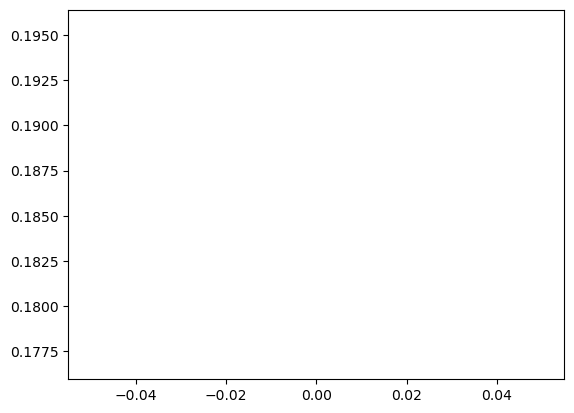

In [27]:
cv.iloc[:, -2].plot()

## Train booster with RMSRD as obj and eval:

In [28]:
params_xgb = dict(
    max_depth=2,
    eta=0.89,
    nthread=1,
    min_child_weight=10,
    disable_default_eval_metric=True,
    colsample_bytree=0.4
    )

params_cv = dict(
    dtrain=X_train_dm,
    num_boost_round=10000,
    nfold=5,
    early_stopping_rounds=100,
    verbose_eval=10,
    seed=1
    )

cv = xgb.cv(params=params_xgb, obj=soft_rank_obj, custom_metric=soft_rank_eval, maximize=False, **params_cv)

[0]	train-RMSRD:464.11286+5.24529	test-RMSRD:113.95872+3.77102
[10]	train-RMSRD:448.90484+6.29871	test-RMSRD:110.72165+3.60732
[20]	train-RMSRD:448.49780+7.25757	test-RMSRD:111.52253+3.42674
[30]	train-RMSRD:449.71204+6.74144	test-RMSRD:111.45622+3.43290
[40]	train-RMSRD:450.46785+7.78575	test-RMSRD:111.40977+3.04551
[50]	train-RMSRD:450.99827+7.95089	test-RMSRD:111.77040+2.98837
[60]	train-RMSRD:450.97777+7.77330	test-RMSRD:111.72489+3.07796
[70]	train-RMSRD:450.92449+7.68932	test-RMSRD:111.86679+3.12742
[80]	train-RMSRD:450.92904+7.61013	test-RMSRD:111.90488+3.14960
[90]	train-RMSRD:451.06149+7.86541	test-RMSRD:111.99201+3.06353
[100]	train-RMSRD:451.33593+7.78796	test-RMSRD:112.08781+3.10494
[109]	train-RMSRD:451.48800+7.94186	test-RMSRD:112.14379+3.08497


In [29]:
cv

,train-RMSRD-mean,train-RMSRD-std,test-RMSRD-mean,test-RMSRD-std
0,464.112857,5.245286,113.958722,3.771023
1,457.967211,5.896463,114.404435,4.716227
2,454.603217,5.385760,112.597849,2.951941
3,452.557425,3.949165,110.837035,2.857023
4,452.091174,4.825183,111.700581,3.487588
5,452.310742,5.828955,111.630373,3.165616
6,449.812800,5.782944,111.374323,3.358924
7,449.583654,5.977913,111.260879,3.423131
8,449.085841,6.363720,111.096003,3.905872
9,449.031041,6.499111,110.742294,3.699901


<Axes: >

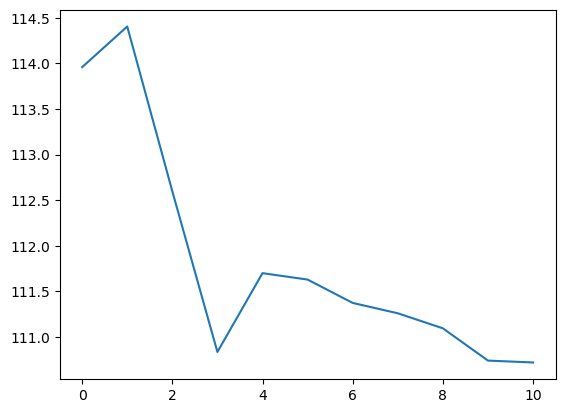

In [30]:
cv.iloc[:, -2].plot()